# Chess Analysis: 

Since when we started walking backwards, chess is a popular game. Once called a game for those who were "cult", it has become increasingly popular, even more in the past 4 years (unfortunately, due to the 2020 pandemics).

This game is base on a 64 squared-type forms that are displayed alphanumerically, in both white and black colors. The main goal is to trap the opponent king in such way that he wouldn't survive to the next move. It's also known as "checkmate".

This dataset, kindly available at Kaggle, is a web scraping with 20k games, all with one objective: win the match at all costs.

But in a world where a victory may cost time and patience, <b>what are the most likely ways to win a match?</b>

We're going to check it, with some goals to achieve:
- To win, you need a strategy which begins at the opening. What are the first play openings that are most likely to win a game for you? 
- The strategy also needs a rating status to be set. We're going to check what are the best rates to these openings.
- To go even further into the analysis, we might see: if I start a game, what strategy should I take with white pieces? And if I'm second, with blacks?
- At last at these considerations, we will see if the time of the match influences at the final results, given your strategy.

In [1]:
# suprimir os warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
# libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import numpy as np
import math
import re

from scipy.stats import norm

In [3]:
df = pd.read_csv('./archive/chess_games.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   game_id            20058 non-null  int64 
 1   rated              20058 non-null  bool  
 2   turns              20058 non-null  int64 
 3   victory_status     20058 non-null  object
 4   winner             20058 non-null  object
 5   time_increment     20058 non-null  object
 6   white_id           20058 non-null  object
 7   white_rating       20058 non-null  int64 
 8   black_id           20058 non-null  object
 9   black_rating       20058 non-null  int64 
 10  moves              20058 non-null  object
 11  opening_code       20058 non-null  object
 12  opening_moves      20058 non-null  int64 
 13  opening_fullname   20058 non-null  object
 14  opening_shortname  20058 non-null  object
 15  opening_response   1207 non-null   object
 16  opening_variation  14398 non-null  objec

In [4]:
df.describe()

,game_id,turns,white_rating,black_rating,opening_moves
count,20058.000000,20058.000000,20058.000000,20058.000000,20058.000000
mean,10029.500000,60.465999,1596.631868,1588.831987,4.816981
std,5790.390185,33.570585,291.253376,291.036126,2.797152
min,1.000000,1.000000,784.000000,789.000000,1.000000
25%,5015.250000,37.000000,1398.000000,1391.000000,3.000000
50%,10029.500000,55.000000,1567.000000,1562.000000,4.000000
75%,15043.750000,79.000000,1793.000000,1784.000000,6.000000
max,20058.000000,349.000000,2700.000000,2723.000000,28.000000


### Little note:

- Average of 60 rounds is really a thing! This can tell us that most of the games are not "fast games", such as bullet games (less than 5 min on the clock).

In [5]:
df.drop(['opening_response', 'white_id', 'black_id'], axis=1, inplace=True)
df.reset_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   index              20058 non-null  int64 
 1   game_id            20058 non-null  int64 
 2   rated              20058 non-null  bool  
 3   turns              20058 non-null  int64 
 4   victory_status     20058 non-null  object
 5   winner             20058 non-null  object
 6   time_increment     20058 non-null  object
 7   white_rating       20058 non-null  int64 
 8   black_rating       20058 non-null  int64 
 9   moves              20058 non-null  object
 10  opening_code       20058 non-null  object
 11  opening_moves      20058 non-null  int64 
 12  opening_fullname   20058 non-null  object
 13  opening_shortname  20058 non-null  object
 14  opening_variation  14398 non-null  object
dtypes: bool(1), int64(6), object(8)
memory usage: 2.2+ MB


In [6]:
df.head(5)

,index,game_id,rated,turns,victory_status,winner,time_increment,white_rating,black_rating,moves,opening_code,opening_moves,opening_fullname,opening_shortname,opening_variation
0,0,1,False,13,Out of Time,White,15+2,1500,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,5,Slav Defense: Exchange Variation,Slav Defense,Exchange Variation
1,1,2,True,16,Resign,Black,5+10,1322,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,4,Nimzowitsch Defense: Kennedy Variation,Nimzowitsch Defense,Kennedy Variation
2,2,3,True,61,Mate,White,5+10,1496,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,3,King's Pawn Game: Leonardis Variation,King's Pawn Game,Leonardis Variation
3,3,4,True,61,Mate,White,20+0,1439,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,3,Queen's Pawn Game: Zukertort Variation,Queen's Pawn Game,Zukertort Variation
4,4,5,True,95,Mate,White,30+3,1523,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,5,Philidor Defense,Philidor Defense,NaN


## Notes:

- As can be seen at the dataframe info, opening responses are the least useful to this dataset, due to a large number of missing data. It'll be removed for a better analysis.
- Also, we'll get rated chess games, as non-rated matches can contain friendly games that must have outliers to our final results

- Though we are looking at opening strategies, we can even analyze the game for numbers of turns: if the average is around 60 turns, games are really extensive! But we will get to check how to make games a little "faster", if possible.

In [7]:
# Analyzing data from the small parts
df = df[df['rated'] == True]

# Checking first results of average players, defined by rating mean
average_rating_white = df['white_rating'].mean()
average_rating_black = df['black_rating'].mean()

# Looking for the standard deviation of each type of chess piece.
deviation_white = np.std(df['white_rating'])
deviation_black = np.std(df['black_rating'])

print(f"""Average white have a mean of {int(average_rating_white)} of rating, while black has {int(average_rating_black)}.
Respectively, white has a standard deviation of {int(deviation_white)}, while black has {int(deviation_black)}""")


Average white have a mean of 1597 of rating, while black has 1593.
Respectively, white has a standard deviation of 284, while black has 289


In [8]:
df = df.loc[((df['white_rating'] - df['black_rating']) <= 350) & ((df['white_rating'] - df['black_rating']) >= -350)]
df['winner_status'] = df.apply(lambda row: 
                               'greater wins' if ((row['winner'] == 'White' and row['white_rating'] > row['black_rating']) or 
                                                  (row['winner'] == 'Black' and row['black_rating'] > row['white_rating'])) 
                               else 'minor rating wins' if ((row['winner'] == 'White' and row['white_rating'] < row['black_rating']) or 
                                                            (row['winner'] == 'Black' and row['black_rating'] < row['white_rating'])) 
                               else 'draw', axis=1)

df['winner_status'].value_counts(), df['winner_status'].count()

rating_diff = np.array(df['white_rating'] - df['black_rating'])

# # Looking for the standard deviation
deviation = np.std(rating_diff)

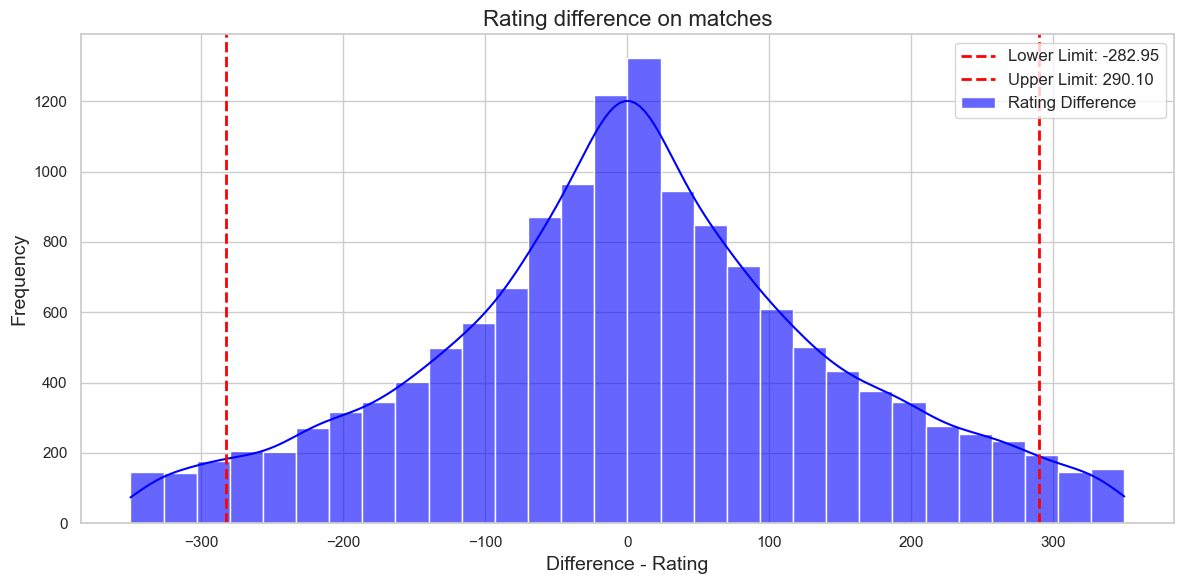

In [9]:
## Now we proceed to check the range of rating difference

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

sns.histplot(rating_diff, bins=30, kde=True, color="blue", label="Rating Difference", alpha=0.6)

plt.axvline(rating_diff.mean() - 2*deviation, color="red", linestyle="--", linewidth=2, label=f"Lower Limit: {rating_diff.mean() - 2*deviation:.2f}")
plt.axvline(rating_diff.mean() + 2*deviation, color="red", linestyle="--", linewidth=2, label=f"Upper Limit: {rating_diff.mean() + 2*deviation:.2f}")

plt.title("Rating difference on matches", fontsize=16)
plt.xlabel("Difference - Rating", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

As can be seen below, average chess players are rated at around 1590. This rating is a calculation based on the players wins and loses, being a factor to the type of opening that can be seen over the games.

It is important to notice the standard deviation, with a value around 287 for both sides of the board. It may indicate some sort of problem, but also can indicate that there's a range of who the player can get as its opponent, being this a hypothesis from the current model of online games, that are held by range of rating, not by the exactly same range.

## Checking distribution

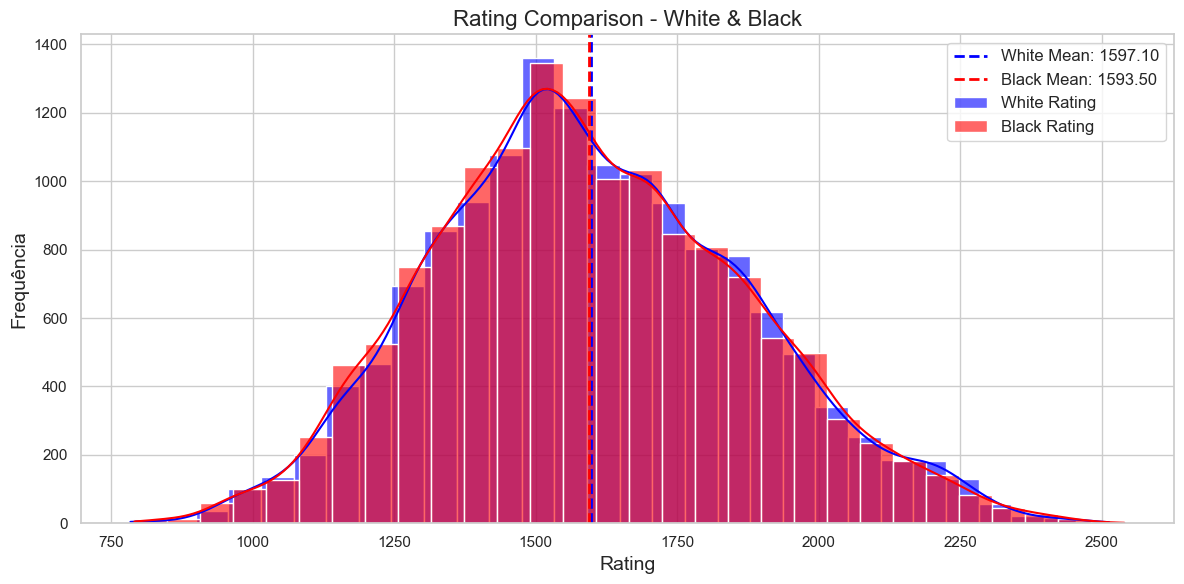

In [10]:
# Configuração para o estilo dos gráficos
sns.set(style="whitegrid")

# Criar os histogramas comparativos
plt.figure(figsize=(12, 6))

# Histograma para 'white_rating'
sns.histplot(df['white_rating'], bins=30, kde=True, color="blue", label="White Rating", alpha=0.6)

# Histograma para 'black_rating'
sns.histplot(df['black_rating'], bins=30, kde=True, color="red", label="Black Rating", alpha=0.6)

# Adicionar linhas verticais para as médias
plt.axvline(average_rating_white, color="blue", linestyle="--", linewidth=2, label=f"White Mean: {average_rating_white:.2f}")
plt.axvline(average_rating_black, color="red", linestyle="--", linewidth=2, label=f"Black Mean: {average_rating_black:.2f}")

# Adicionar título e legendas
plt.title("Rating Comparison - White & Black", fontsize=16)
plt.xlabel("Rating", fontsize=14)
plt.ylabel("Frequência", fontsize=14)
plt.legend(fontsize=12)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

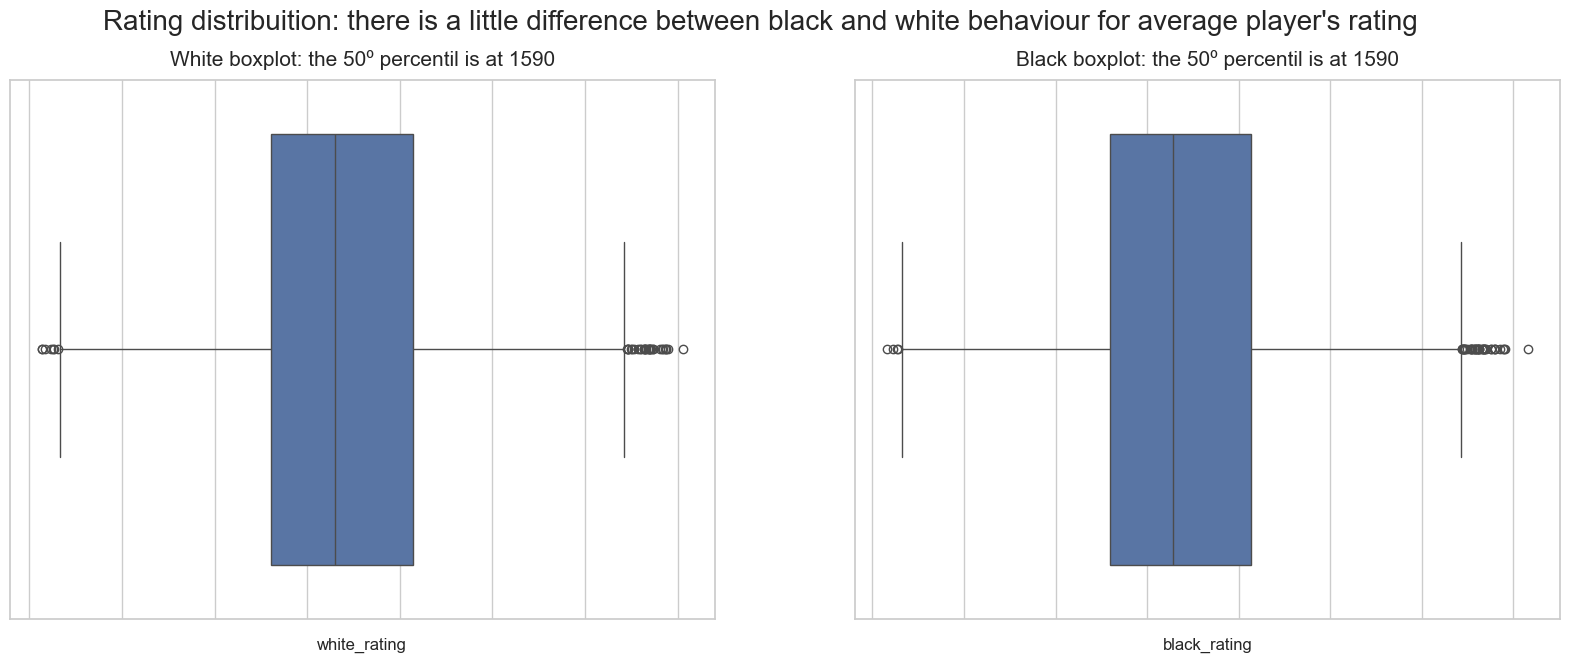

In [11]:
fig, ax = plt.subplots(1,2)

fig.set_figheight(7)
fig.set_figwidth(20)

plt.suptitle("Rating distribuition: there is a little difference between black and white behaviour for average player's rating", fontsize=20)

plt.subplot(1,2,1)
sns.boxplot(x=df['white_rating']).set(xticklabels=[])
plt.title("White boxplot: the 50º percentil is at 1590", loc='center', pad=10, fontsize=15)

plt.subplot(1,2,2)
sns.boxplot(x=df['black_rating']).set(xticklabels=[])
plt.title("Black boxplot: the 50º percentil is at 1590", loc='center', pad=10, fontsize=15)

plt.show()

In [12]:
# Checking new results of average players, defined by rating mean after the trust interval reduction on percetile
average_rating_white = df['white_rating'].mean()
average_rating_black = df['black_rating'].mean()

# Looking for the standard deviation of each type of chess piece.
deviation_white = np.std(df['white_rating'])
deviation_black = np.std(df['black_rating'])

print(f"""Average white have a mean of {int(average_rating_white)} of rating, while black has {int(average_rating_black)}.
Respectively, white has a standard deviation of {int(deviation_white)}, while black has {int(deviation_black)}""")

Average white have a mean of 1596 of rating, while black has 1593.
Respectively, white has a standard deviation of 275, while black has 276


## First conclusions

- We could evaluate the average of rating for white and black, and balance it to check that both averages are close to the same values. This can imply that we have the same average, as chess ratings are not usually equal, but close to a certain range (mainly 100 points) for the average levels, where there are more players.

- Also, this can be an indicator to what we will look for: the players' most used openings will be part of a not adjusted normal distribution, but which has a peak for the average player, with or without any data noise as the outliers.

## Changing the results by evaluating the best fit values
Some points were added at the first draft of the analysis to a better fit of the dataset (above):
- There was no need to verify the not rated games. This is due to a lack of rating compatibility between the rated and non-rated games, as we can have friendly games or tests.

You can check as the heads and tails from the boxplot have lowered its appearance from the initial and final visualization. Also, this can be very useful as higher and lower chess games have different directions: usually, lower rated games are not very used to get the opening theories, on the contrary to the higher games, where the opening are deeply understood and used (what is not our primary goal here)

In [13]:
# A point that can determinate a win is how the game is started, by both players.
# If white plays with pawn of knight, which is the most successful rate?
# If black plays some moves for a defense, as a pawn or knight variation, which is its rate of success?

# # for test purpouses
# df = df.copy()

# Extraction of first plays from black and white
df['white_first_move'] = df['moves'].astype(str).apply(lambda x: re.search(r'(\w+)\s', x).group(1).strip() if re.search(r'(\w+)\s', x) else '')
df['black_first_move'] = df['moves'].astype(str).apply(lambda x: re.search(r'(\w+)\s(\w+)', x).group(2).strip() if re.search(r'(\w+)\s(\w+)', x) else '')

In [14]:
## Checking both pieces' first moves.

white_fmoves = df['white_first_move'].value_counts().sort_values(ascending=False)
black_fmoves = df['black_first_move'].value_counts().sort_values(ascending=False)

x1 = white_fmoves.head(5).index
y1 = white_fmoves.head(5).values

x2 = black_fmoves.head(5).index
y2 = black_fmoves.head(5).values

x1, y1

(Index(['e4', 'd4', 'c4', 'Nf3', 'e3'], dtype='object', name='white_first_move'),
 array([9090, 3328,  514,  464,  285], dtype=int64))

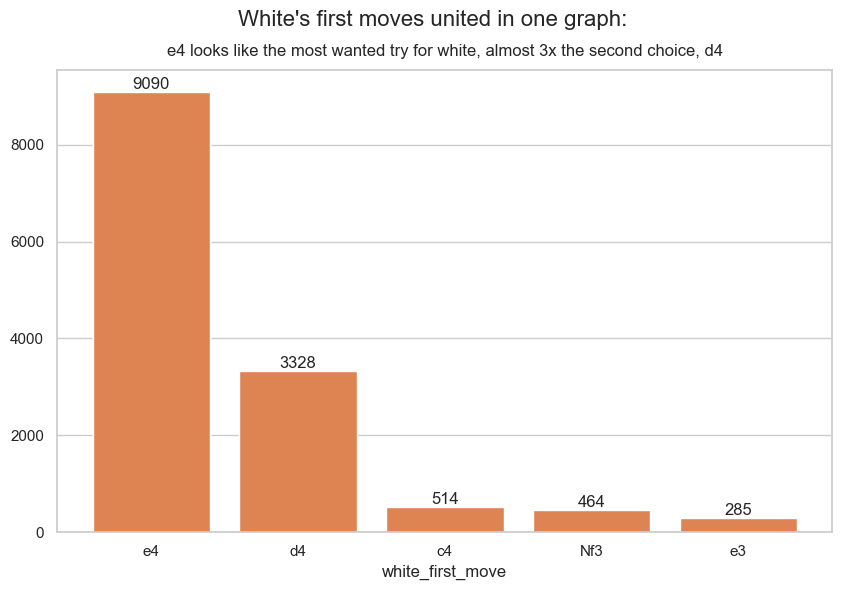

In [15]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(6)

sns.barplot(x=x1, y=y1)

bars1 =  ax.bar(x1, y1)
ax.bar_label(bars1)

plt.suptitle("White's first moves united in one graph:", fontsize=16)
plt.title("e4 looks like the most wanted try for white, almost 3x the second choice, d4", loc='center', pad=10, fontsize=12)

plt.show()

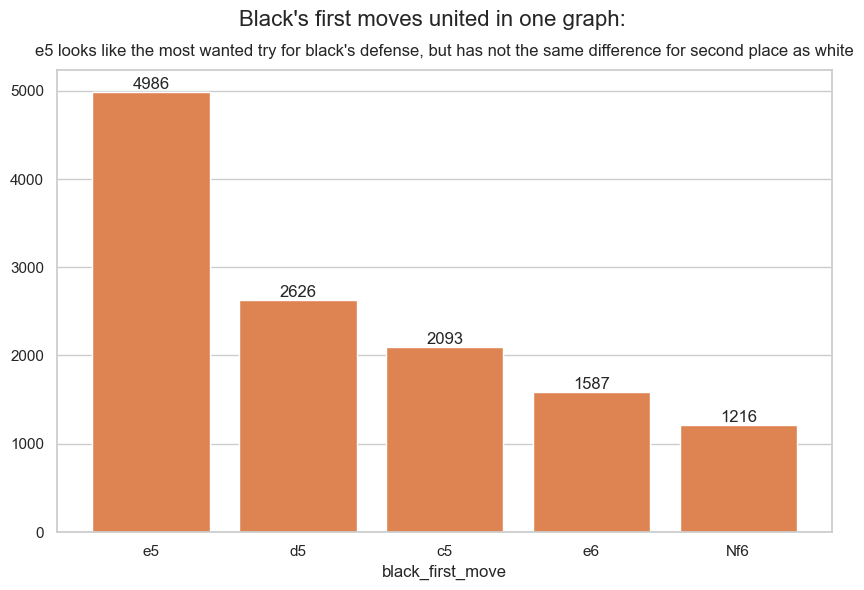

In [16]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(6)

sns.barplot(x=x2, y=y2)

bars2 =  ax.bar(x2, y2)
ax.bar_label(bars2)

plt.suptitle("Black's first moves united in one graph:", fontsize=16)
plt.title("e5 looks like the most wanted try for black's defense, but has not the same difference for second place as white", loc='center', pad=10, fontsize=12)

plt.show()

In [17]:
## Here we check the first moves that led to a victory for each set of pieces

better_white_fmoves = df['white_first_move'].loc[df['winner'] == 'White'].value_counts().sort_values(ascending=False)
better_black_fmoves = df['black_first_move'].loc[df['winner'] == 'Black'].value_counts().sort_values(ascending=False)

x1 = better_white_fmoves.head(5).index
y1 = better_white_fmoves.head(5).values

x2 = better_black_fmoves.head(5).index
y2 = better_black_fmoves.head(5).values

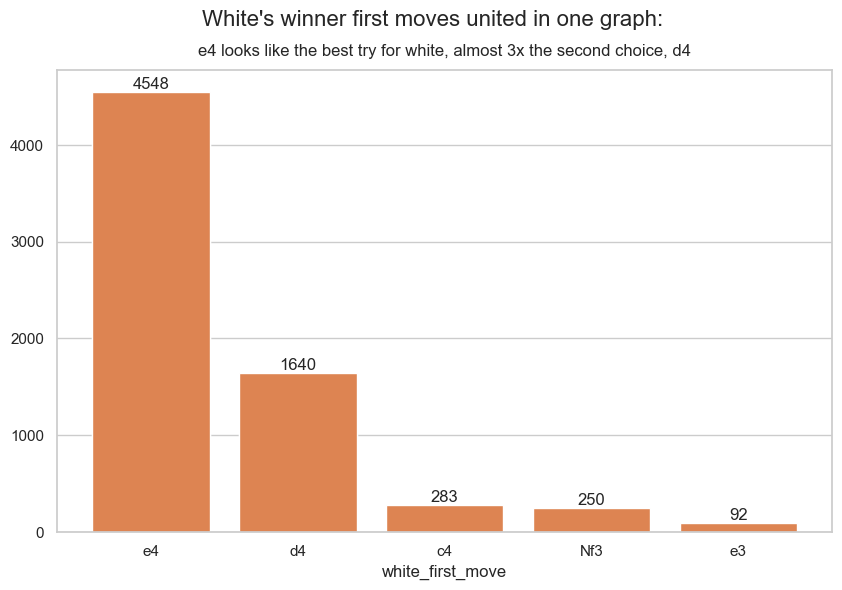

In [18]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(6)

sns.barplot(x=x1, y=y1)

bars1 =  ax.bar(x1, y1)
ax.bar_label(bars1)

plt.suptitle("White's winner first moves united in one graph:", fontsize=16)
plt.title("e4 looks like the best try for white, almost 3x the second choice, d4", loc='center', pad=10, fontsize=12)

plt.show()

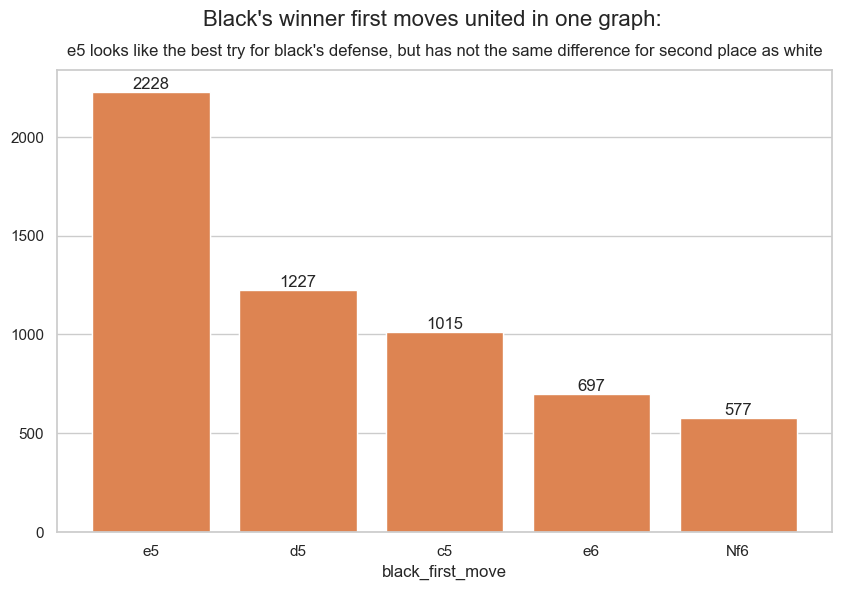

In [19]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(6)

sns.barplot(x=x2, y=y2)

bars2 =  ax.bar(x2, y2)
ax.bar_label(bars2)

plt.suptitle("Black's winner first moves united in one graph:", fontsize=16)
plt.title("e5 looks like the best try for black's defense, but has not the same difference for second place as white", loc='center', pad=10, fontsize=12)

plt.show()

In [20]:
## Success rate for white and blacks preferred choices:

success_rate_white_top1 = round(df.loc[(df['winner'] == 'White') & (df['white_first_move'] == 'e4')].shape[0]/df.shape[0], 4) * 100 
success_rate_black_top1 = round(df.loc[(df['winner'] == 'Black') & (df['black_first_move'] == 'e5')].shape[0]/df.shape[0], 4) * 100 
success_rate_white_top2 = round(df.loc[(df['winner'] == 'White') & (df['white_first_move'] == 'd4')].shape[0]/df.shape[0], 4) * 100 
success_rate_black_top2 = round(df.loc[(df['winner'] == 'Black') & (df['black_first_move'] == 'd5')].shape[0]/df.shape[0], 4) * 100 

other_success_rates = 100 - success_rate_white_top1 - success_rate_black_top1 - success_rate_black_top2 - success_rate_white_top2

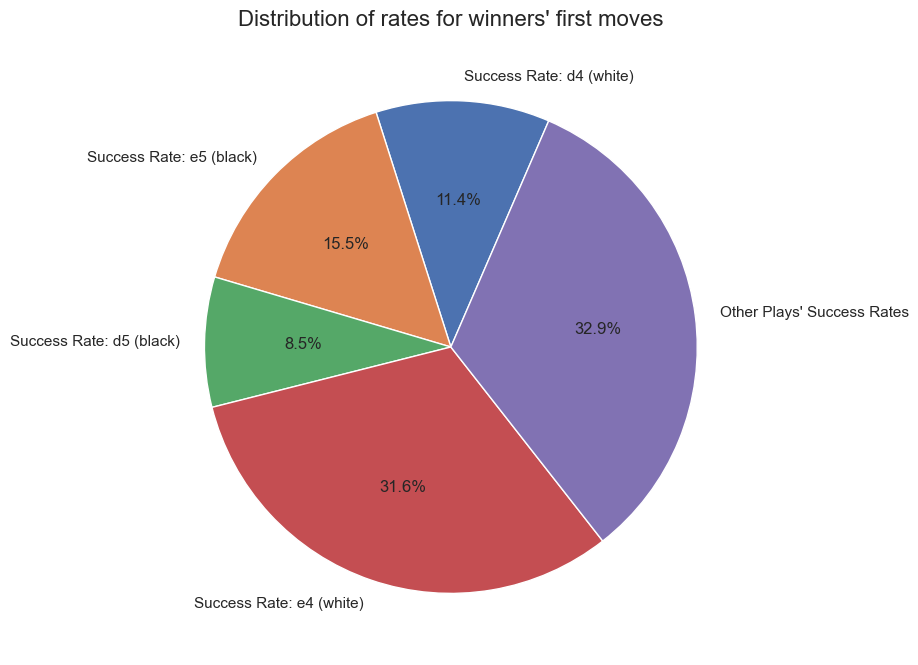

In [21]:
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(8)

plt.pie(
    [success_rate_white_top2, success_rate_black_top1, success_rate_black_top2, success_rate_white_top1, other_success_rates],
    labels=[
            "Success Rate: d4 (white)", 
            "Success Rate: e5 (black)", 
            "Success Rate: d5 (black)", 
            "Success Rate: e4 (white)", 
            "Other Plays' Success Rates"
        ],
    # colors="blue",
    autopct='%1.1f%%',
    startangle= -180 * success_rate_white_top1

    )

plt.title("Distribution of rates for winners' first moves", loc='center', pad=10, fontsize=16)

plt.show()

In [22]:
## now let's check the best opening, with its respective names

better_white__name_moves = df['opening_fullname'].loc[df['winner'] == 'White'].value_counts().sort_values(ascending=False)
better_black__name_moves = df['opening_fullname'].loc[df['winner'] == 'Black'].value_counts().sort_values(ascending=False)

x1 = better_white__name_moves.head(6).index
y1 = better_white__name_moves.head(6).values

x2 = better_black__name_moves.head(6).index
y2 = better_black__name_moves.head(6).values

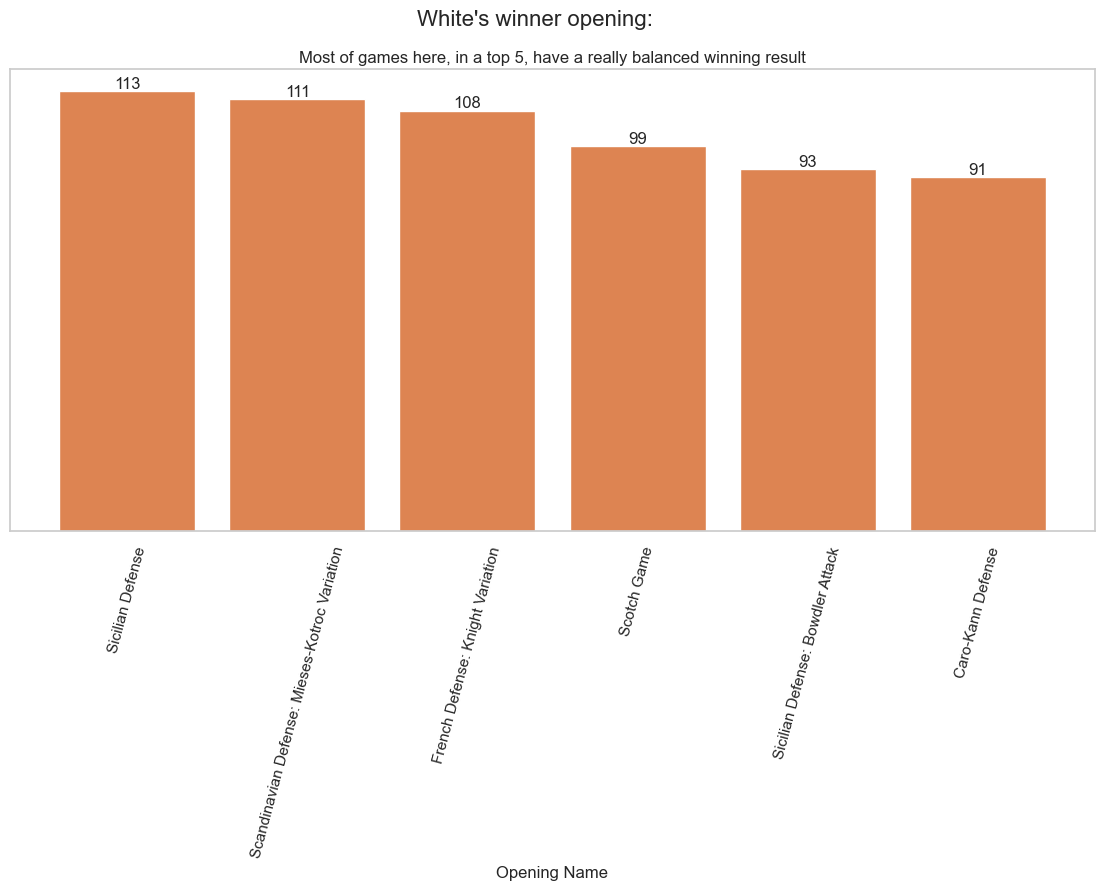

In [23]:
fig, ax = plt.subplots()
fig.set_figwidth(14)
fig.set_figheight(6)

sns.barplot(x=x1, y=y1)

bars1 =  ax.bar(x1, y1)
ax.bar_label(bars1)

plt.suptitle("White's winner opening:", fontsize=16)
plt.title("Most of games here, in a top 5, have a really balanced winning result", loc='center', pad=5, fontsize=12)

plt.xticks(rotation=75)
plt.gca().set_yticks([])
plt.xlabel("Opening Name")

plt.show()

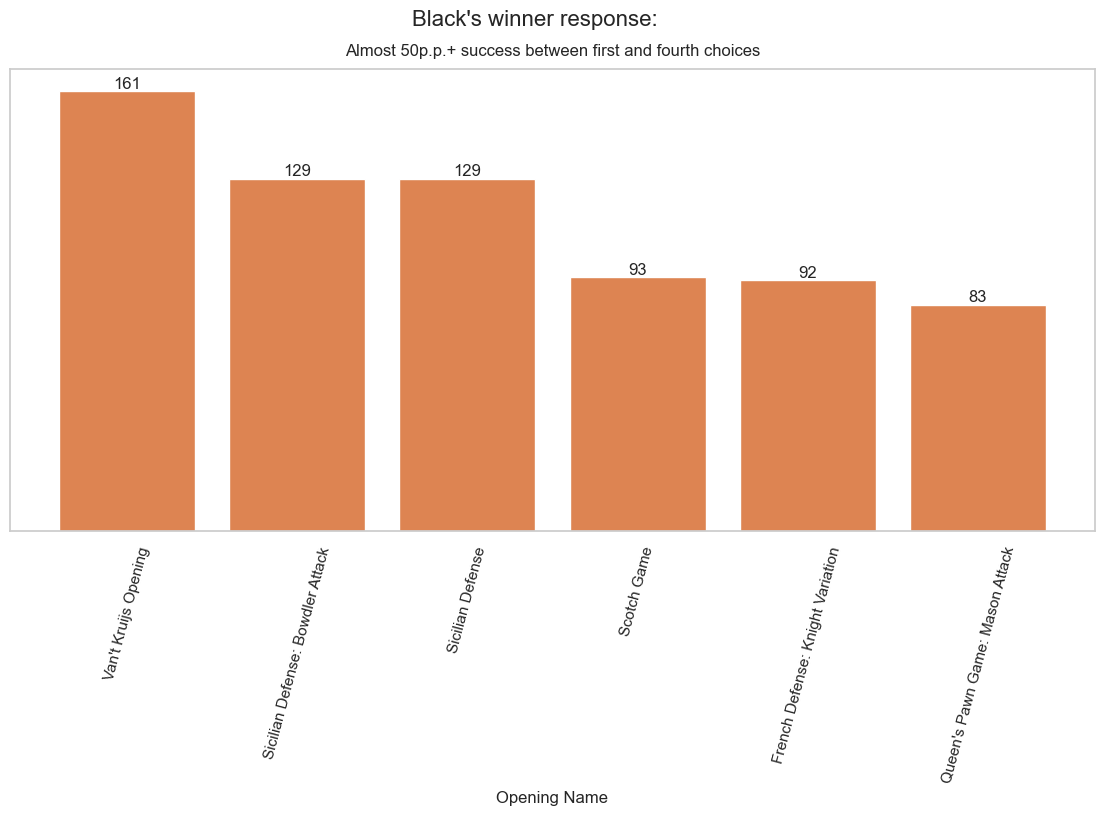

In [24]:
fig, ax = plt.subplots()
fig.set_figwidth(14)
fig.set_figheight(6)

sns.barplot(x=x2, y=y2)

bars2 =  ax.bar(x2, y2)
ax.bar_label(bars2)

plt.suptitle("Black's winner response:", fontsize=16)
plt.title("Almost 50p.p.+ success between first and fourth choices", loc='center', pad=10, fontsize=12)

plt.xticks(rotation=75)
plt.gca().set_yticks([])
plt.xlabel("Opening Name")

plt.show()

## The best by test

This title is related to a phrase of Bob Fischer, one of the best players of all-time. Statistically presented at the pie chart above, we can agree with him. In a sample of more than 15k players, almost 32% of the total has success with white pieces by playing the "e4", almost 3x the second main choice, "d5". 

Also, the response "e5" has won many games, but may not be an indicator of e4 being the most played game in general.

it is important to notice 2 points:
- First of all, most games are used to start with the play e4. But many games start with other plays, as shown at the graph above. This may change our way to understard strategies, as we'll check on the next steps.
- Also this implies in a important thing: if our games have a mean of 1600 for both black and white pieces, this means all games are mainly destined to have the same results (e.g., all games rated has e4 as it's most sucessfull plays in start?)

In [25]:
## A little of feature engineering:
## Let's start by separating the rating of white and black pieces

# Verifying tiers
def verify_tier(row):
    if row['white_tier'] == row['black_tier']:
        return 'same tier'
    elif row['white_tier'] > row['black_tier']:
        return 'upper tier', 'lower tier'
    elif row['white_tier'] < row['black_tier']:
        return 'lower tier', 'upper tier'

# Criando as faixas dinâmicas para cada coluna
white_tier = pd.cut(df['white_rating'], bins=range(0, 3001, 150))
black_tier = pd.cut(df['black_rating'], bins=range(0, 3001, 150))

# Criando uma nova coluna para cada faixa
df['white_tier'] = white_tier
df['black_tier'] = black_tier

# Verificando o tier
df['white_tier'], df['black_tier'] = zip(*df.apply(verify_tier, axis=1))

df


,index,game_id,rated,turns,victory_status,winner,time_increment,white_rating,black_rating,moves,opening_code,opening_moves,opening_fullname,opening_shortname,opening_variation,winner_status,white_first_move,black_first_move,white_tier,black_tier
1,1,2,True,16,Resign,Black,5+10,1322,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,4,Nimzowitsch Defense: Kennedy Variation,Nimzowitsch Defense,Kennedy Variation,minor rating wins,d4,Nc6,s,a
2,2,3,True,61,Mate,White,5+10,1496,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,3,King's Pawn Game: Leonardis Variation,King's Pawn Game,Leonardis Variation,minor rating wins,e4,e5,s,a
3,3,4,True,61,Mate,White,20+0,1439,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,3,Queen's Pawn Game: Zukertort Variation,Queen's Pawn Game,Zukertort Variation,minor rating wins,d4,d5,s,a
4,4,5,True,95,Mate,White,30+3,1523,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,5,Philidor Defense,Philidor Defense,NaN,greater wins,e4,e5,upper tier,lower tier
6,6,7,True,33,Resign,White,10+0,1520,1423,d4 d5 e4 dxe4 Nc3 Nf6 f3 exf3 Nxf3 Nc6 Bb5 a6 ...,D00,10,Blackmar-Diemer Gambit: Pietrowsky Defense,Blackmar-Diemer Gambit,Pietrowsky Defense,greater wins,d4,d5,upper tier,lower tier
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20052,20052,20053,True,37,Resign,White,10+10,1219,1250,c4 e6 d4 b6 Nc3 Bb7 Nf3 g6 h4 Bg7 Bg5 f6 Bf4 d...,A40,4,English Defense,English Defense,NaN,minor rating wins,c4,e6,s,a
20054,20054,20055,True,82,Mate,Black,10+0,1233,1196,d4 d6 Bf4 e5 Bg3 Nf6 e3 exd4 exd4 d5 c3 Bd6 Bd...,A41,2,Queen's Pawn,Queen's Pawn,NaN,minor rating wins,d4,d6,upper tier,lower tier
20055,20055,20056,True,35,Mate,White,10+0,1219,1286,d4 d5 Bf4 Nc6 e3 Nf6 c3 e6 Nf3 Be7 Bd3 O-O Nbd...,D00,3,Queen's Pawn Game: Mason Attack,Queen's Pawn Game,Mason Attack,minor rating wins,d4,d5,s,a
20056,20056,20057,True,109,Resign,White,10+0,1360,1227,e4 d6 d4 Nf6 e5 dxe5 dxe5 Qxd1+ Kxd1 Nd5 c4 Nb...,B07,4,Pirc Defense,Pirc Defense,NaN,greater wins,e4,d6,upper tier,lower tier
